# IQR dependend frequency of outlier occurrence within different molecular subsets

### imports

In [1]:
import pickle
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from joblib import load

### functions

In [ ]:
def detect_outliers(
    df: pd.DataFrame, column: str, method: str = "iqr", threshold: float = 1.5
) -> pd.Series:
    """
    Detects outliers in a given column of a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The name of the column to check for outliers.
        method (str): The method to use for outlier detection.
                      Options: 'iqr' (Interquartile Range), 'std' (Standard Deviation).
                      Default: 'iqr'.
        threshold (float): The threshold for outlier detection.
                           For 'iqr' method, it's the number of IQRs to consider as outliers.
                           For 'std' method, it's the number of standard deviations.
                           Default: 1.5.

    Returns:
        pandas.Series: A boolean Series indicating whether each row is an outlier.
    """

    if method == "iqr":
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
    elif method == "std":
        mean = df[column].mean()
        std_dev = df[column].std()
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev
    else:
        raise ValueError("Invalid method. Choose 'iqr' or 'std'.")

    return (df[column] < lower_bound) | (df[column] > upper_bound)

In [3]:
def plot_with_connected_lines(df: pd.DataFrame, iqr_column: str = "threshold"):
    """
    Creates a plot with connected lines using Seaborn, annotating the last point of each line.

    Args:
        df: Pandas DataFrame. The DataFrame should have a column specified by iqr_column
            that will be used as the x-axis, and other columns that will be used as y-axes.
        iqr_column: The name of the column to use as the x-axis. Defaults to 'IQR'.
    """

    if iqr_column not in df.columns:
        raise ValueError(f"Column '{iqr_column}' not found in DataFrame.")

    df_melted = df.melt(id_vars=[iqr_column], var_name="Variable", value_name="Value")

    plt.figure(figsize=(12, 6))
    plt.yscale("log")
    plt.xlim(1, 11)
    ax = sns.lineplot(
        x=iqr_column,
        y="Value",
        hue="Variable",
        marker="o",
        data=df_melted,
        palette="Spectral",
    )

    threshold = 1e-4

    for variable in df_melted["Variable"].unique():
        subset = df_melted[df_melted["Variable"] == variable]

        valid_indices = subset[subset["Value"] > threshold].index
        if not valid_indices.empty:
            last_valid_index = valid_indices[-1]
            last_x = subset.loc[last_valid_index, iqr_column] + 0.1
            last_y = subset.loc[last_valid_index, "Value"]
            ax.annotate(
                variable,
                (last_x, last_y),
                textcoords="offset points",
                xytext=(0, 10),
                ha="left",
            )
        else:
            print(f"No values above threshold for variable: {variable}")

    plt.xlabel("IQR "+iqr_column)
    plt.ylabel("ratio of outliers")
    plt.title("outlier ratio")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.show()

### main code

In [ ]:
def main():
    """
    Analyzes the frequency of outlier occurrence within molecular subsets based on IQR thresholds.
    """
    try:
        X = pd.read_pickle("data/processed/calc_descriptors_final.pkl")
    except FileNotFoundError:
        print("Error: 'data/processed/calc_descriptors_final.pkl' not found.")
        return

    scaler = MinMaxScaler()
    X["Ipc"] = scaler.fit_transform(X["Ipc"].values.reshape(-1, 1))

    scaler = StandardScaler().fit(X)
    scaled = scaler.transform(X)

    try:
        df = pd.read_pickle("data/processed/gap_smile.pkl")
    except FileNotFoundError:
        print("Error: 'data/processed/gap_smile.pkl' not found.")
        return

    y = df["GAP"].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(
        scaled, y, test_size=0.3, random_state=42
    )
    try:
        reg = load("data/processed/reg_NN_MLP.joblib")
    except FileNotFoundError:
        print("Error: 'data/processed/reg_NN_MLP.joblib' not found.")
        return
    gap_pred = reg.predict(scaled)
    df["GAP_P"] = gap_pred
    df_concat = pd.concat([df, X], axis=1, join="inner")
    df_concat["diff"] = df_concat["GAP"] - df_concat["GAP_P"]

    results: Dict[str, List[float]] = {}
    results_tot: Dict[str, List[int]] = {}
    iqr_range = np.array([0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 6.0, 8.0, 10.0])
    results["threshold"] = iqr_range.tolist()
    results_tot["threshold"] = iqr_range.tolist()

    for descr in df_concat.columns:
        if any(sub in descr for sub in ["Num", "fr"]) and "NumRadicalElectrons" not in descr:
            filtered_df = df_concat[df_concat[descr] > 1]
            iqr_percentage: List[float] = []
            iqr_tot: List[int] = []
            for thr in iqr_range:
                outliers = detect_outliers(filtered_df, "diff", threshold=thr)
                num_outliers = len(outliers[outliers == True])
                percentage_outliers = 100 * len(outliers[outliers == True]) / len(
                    outliers
                )
                iqr_percentage.append(percentage_outliers)
                iqr_tot.append(num_outliers)
            results[descr] = iqr_percentage
            results_tot[descr] = iqr_tot

    iqr_df_tot = pd.DataFrame.from_dict(results_tot)
    iqr_df = pd.DataFrame.from_dict(results)
    plot_with_connected_lines(iqr_df)

    iqr_df_tot = iqr_df_tot.set_index("threshold")
    iqr_df = iqr_df.set_index("threshold")

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        iqr_df, annot=iqr_df_tot, cmap="viridis", fmt="5g", norm=LogNorm()
    )
    plt.ylabel("threshold")
    plt.title("outliers vs. IQR-threshold")
    plt.tight_layout()
    plt.savefig("iqr_vs_descriptor_outliers.png")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        iqr_df_tot, annot=iqr_df, cmap="viridis", fmt=".2f", norm=LogNorm()
    )
    plt.ylabel("threshold")
    plt.title("outliers vs. IQR-threshold")
    plt.tight_layout()
    plt.show()

/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


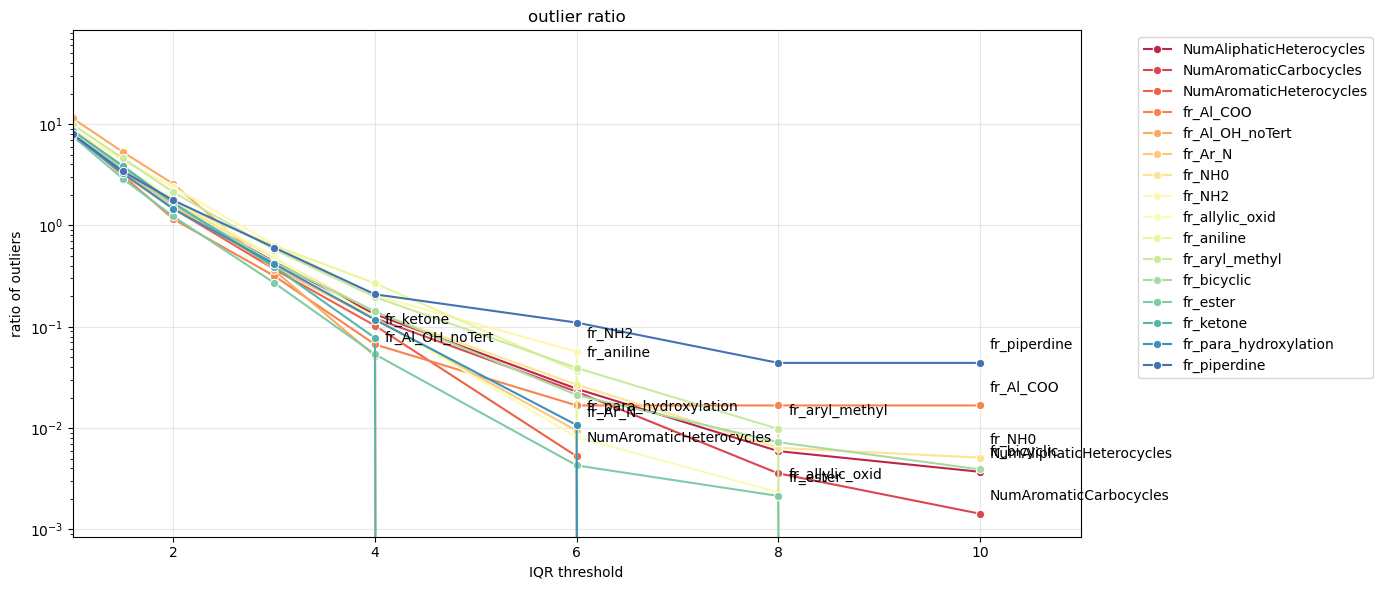

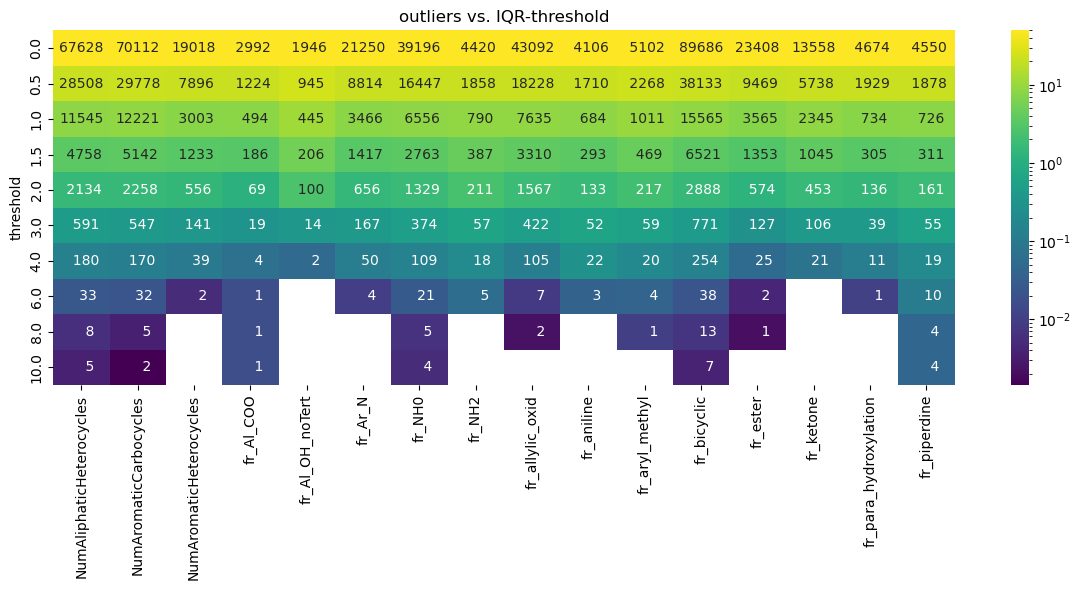

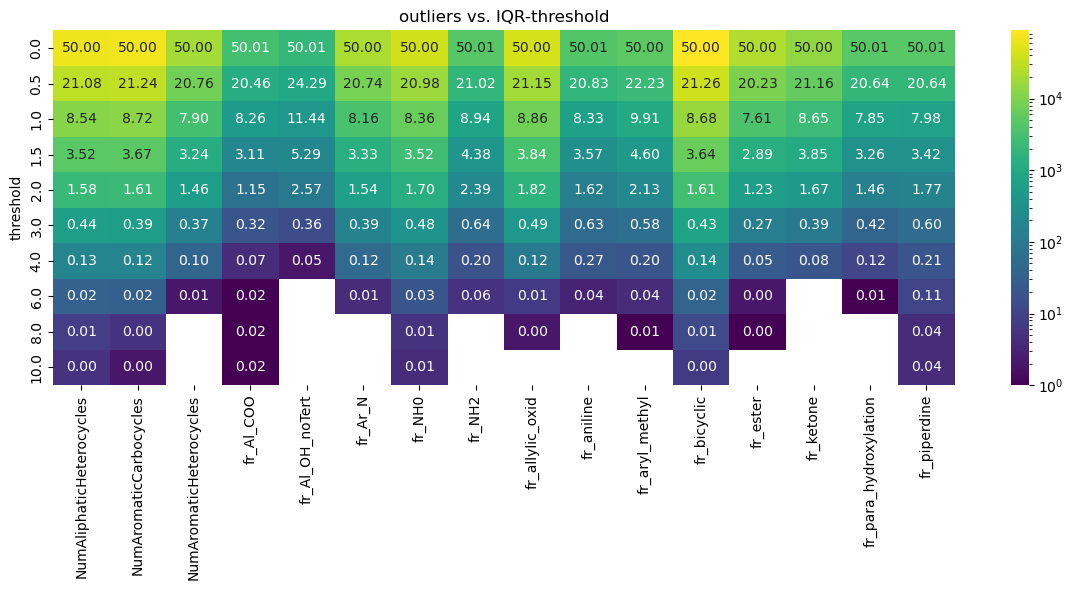

In [5]:
if __name__ == "__main__":
    main()